In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Load and Pre-Process the Data

In [2]:
raw_df = pd.read_csv('../data/founder_V0.3_founder.csv')

In [3]:
raw_df.columns = raw_df.columns.str.replace(' ', '_')
raw_df.columns 

Index(['Full_Name', 'Primary_Job_Title', 'Bio', 'Gender',
       'Number_of_News_Articles', 'Number_of_Founded_Organizations',
       'Number_of_Portfolio_Companies', 'Number_of_Investments_x',
       'Number_of_Partner_Investments', 'Number_of_Lead_Investments_x',
       'Number_of_Exits_x', 'Number_of_Events_x', 'Categories',
       'Headquarters_Location_', 'Operating_Status', 'Founded_Date',
       'Closed_Date', 'Company_Type', 'Number_of_Founders', 'Success',
       'Founder'],
      dtype='object')

In [4]:
raw_df.shape

(18361, 21)

# Normalization

In [5]:
raw_df['Number_of_News_Articles'] = raw_df['Number_of_News_Articles']/raw_df['Number_of_News_Articles'].max()

In [6]:
raw_df['Number_of_Founded_Organizations'] = raw_df['Number_of_Founded_Organizations']/raw_df['Number_of_Founded_Organizations'].max()

In [7]:
raw_df['Number_of_Portfolio_Companies'] = raw_df['Number_of_Portfolio_Companies']/raw_df['Number_of_Portfolio_Companies'].max()

In [8]:
raw_df['Number_of_Investments_x'] = raw_df['Number_of_Investments_x'] / raw_df['Number_of_Investments_x'].max()

In [9]:
raw_df['Number_of_Partner_Investments'] = raw_df['Number_of_Partner_Investments'] /raw_df['Number_of_Partner_Investments'].max()

In [10]:
raw_df['Number_of_Lead_Investments_x'] = raw_df['Number_of_Lead_Investments_x']/ raw_df['Number_of_Lead_Investments_x'].max()

In [11]:
raw_df['Number_of_Exits_x'] = raw_df['Number_of_Exits_x'] / raw_df['Number_of_Exits_x'].max()

In [12]:
raw_df['Number_of_Events_x'] = raw_df['Number_of_Events_x']/ raw_df['Number_of_Events_x'].max()

# OHE Headquarters & Clean the Categories Column

### OHE Headqurters

In [13]:
country_Dummies = pd.get_dummies(raw_df['Headquarters_Location_'])
raw_df_dummies = pd.concat([raw_df, country_Dummies], axis = 1)
raw_df_dummies.shape


(18361, 163)

### A Few Helpful Functions

In [14]:
def get_unique_vals(column_name):
    unique_arr = []
    for val in raw_df_dummies[column_name].values:
        arr = val.split(',')
        for category in arr:
            if category not in unique_arr:
                unique_arr.append(category.strip())
    return unique_arr

In [15]:
def get_all_vals(column_name):
    categories_arr = []
    for val in raw_df_dummies[column_name].values:
        arr = val.split(',')
        categories_arr.append(arr[0].strip())
    return categories_arr


### Clean the Category Column
#### 1. Create Needed DataFrames

In [16]:
category_df = pd.Series(get_all_vals('Categories')) # all categories
cat_counts_series =  pd.Series(pd.Series(get_all_vals('Categories')).value_counts()) # category counts
cat_counts_df = pd.DataFrame(cat_counts_series)
cat_counts_df = cat_counts_df.head(15)
cat_counts_df

0
Software                 818
Health Care              532
Mobile                   467
E-Commerce               400
Analytics                394
Internet                 384
Enterprise Software      352
SaaS                     308
0                        306
Apps                     288
Information Technology   282
FinTech                  240
Medical                  215
Artificial Intelligence  210
Real Estate              196

### 2. Take top 10 Categories, Test if they're in each row, and convert the end values to 0/1

In [17]:
for cat in cat_counts_df.index:
    category_bool = raw_df_dummies["Categories"].apply(lambda x: cat in x)
    raw_df_dummies[cat] = category_bool*1 # convert to True/False
  

# Next, make final changes and create **_clean_df_**

In [18]:
raw_df_dummies['Gender'].value_counts() # 131 people responded 2
index_names = raw_df_dummies[raw_df_dummies["Gender"] == 2].index
raw_df_dummies.drop(index_names, inplace=True)

In [19]:
df_filter_date = raw_df_dummies[raw_df_dummies['Founded_Date'] >= 1995]
df_filter_date.shape

(17900, 177)

In [20]:
clean_df = pd.DataFrame(df_filter_date)
clean_df.head(5)

Full_Name                       Primary_Job_Title  \
0        Elon Musk       Chairman, Product Architect & CEO   
1      JB Straubel                      Co-Founder and CTO   
2  Mark Zuckerberg                           Founder & CEO   
3       Ross Mason      Founder and VP of Product Strategy   
4     Rahul Gandhi  Co-Founder & SVP of Finance Operations   

                                                 Bio  Gender  \
0  Elon co-founded Tesla and continues to oversee...       1   
1  The story of JB Straubel's career started at a...       1   
2  Mark Zuckerberg is the founder and CEO of Face...       1   
3  Created the Mule Project, Founded MuleSoft, go...       1   
4  Rahul is a Co-founder & Senior Vice President ...       1   

   Number_of_News_Articles  Number_of_Founded_Organizations  \
0                 0.734069                         0.538462   
1                 0.005082                         0.153846   
2                 1.000000                         0.769231   
3                 0.006505                         0.076923   
4                 0.043754                         0.076923   

   Number_of_Portfolio_Companies  Number_of_Investments_x  \
0                       0.112245                 0.187500   
1                       0.010204                 0.008929   
2                       0.061224                 0.062500   
3                       0.061224                 0.062500   
4                       0.000000                 0.000000   

   Number_of_Partner_Investments  Number_of_Lead_Investments_x  ...  \
0                            0.0                           1.0  ...   
1                            0.0                           0.0  ...   
2                            0.0                           0.0  ...   
3                            0.0                           0.0  ...   
4                            0.0                           0.0  ...   

   Analytics  Internet Enterprise Software SaaS  Apps  Information Technology  \
0          0         0                   0    0     0                       0   
1          0         0                   0    0     0                       0   
2          0         0                   0    0     0                       0   
3          0         0                   1    0     1                       0   
4          0         1                   0    0     0                       0   

   FinTech  Medical  Artificial Intelligence  Real Estate  
0        0        0                        0            0  
1        0        0                        0            0  
2        0        0                        0            0  
3        1        0                        0            0  
4        0        0                        0            0  

[5 rows x 177 columns]

In [21]:
X = clean_df.drop(['Primary_Job_Title', 'Operating_Status', 'Company_Type', 'Success', 'Full_Name', 'Bio', 'Categories', 'Headquarters_Location_', 'Founder', 'Closed_Date', '0'], axis = 1)
y = clean_df['Success'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1234)
X.shape


(17900, 166)

# XGBoost

In [22]:
xgb_classifier = xgb.XGBClassifier(n_estimators= 1000, objective='binary:logistic', booster='dart', learning_rate=.3, colsample_bytree=.3, reg_alpha= .3, random_state = 1234)
xgb_classifier.fit(x_train, y_train)
xgb_y_pred = xgb_classifier.predict(x_test)

xgb_train_score = round(xgb_classifier.score(x_train, y_train)*100, 3)
xgb_test_score = round(xgb_classifier.score(x_test, y_test)*100, 3)

print("Train Accuracy: " + str(xgb_train_score))
print("Test Accuracy: " + str(xgb_test_score))


Train Accuracy: 90.608
Test Accuracy: 79.413


In [26]:
%%capture
xgb.plot_importance(xgb_classifier)
plt.rcParams['figure.figsize'] = [50, 30]

In [27]:
plt.savefig("feature-importance.png") #easier to inspect as image

<Figure size 3600x2160 with 0 Axes>

In [28]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))

print("RMSE: " + str(rmse))
print("MSE: " + str(mean_squared_error(y_test, xgb_y_pred)))

RMSE: 0.45372449987598146
MSE: 0.2058659217877095


In [29]:
params = {
    'booster': ['gbtree', 'dart'],
    'objective': ['binary:hinge', 'binary:logitraw'],
    'max_depth': [4, 5, 6]
}

gs_clf_xgb = GridSearchCV(xgb_classifier, param_grid=params, 
                          cv=StratifiedKFold(n_splits=3), scoring='recall')
gs_clf_xgb.fit(x_train, y_train)

print(gs_clf_xgb.best_estimator_.get_params())

{'objective': 'binary:hinge', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.3, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1000, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 1234, 'reg_alpha': 0.3, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


# KNearestNeighbors

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 10, algorithm= 'auto', n_jobs=-1)

knn.fit(x_train, y_train)

knn_y_pred = knn.predict(x_test)

knn_train_score = round(knn.score(x_train, y_train)*100, 2)
knn_test_score = round(knn.score(x_test, y_test)*100, 2)

print(knn_train_score)
print(knn_test_score)


79.66
76.12


In [31]:
from sklearn.model_selection import cross_val_score 
k_neighbor = list(range(1, 24, 2))

cross_val_scores = []

for k in k_neighbor:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring = 'accuracy')
    cross_val_scores.append(scores.mean())
print(cross_val_scores)

[0.7875, 0.7620810055865922, 0.7585893854748604, 0.7599860335195532, 0.7569832402234636, 0.7578910614525138, 0.7553072625698324, 0.7542597765363128, 0.7548882681564246, 0.7539804469273743, 0.7527932960893855, 0.7530027932960894]


In [32]:
print(max(cross_val_scores))

0.7875


In [33]:
misclassification_error = [1 - score for score in cross_val_scores]

best_k = k_neighbor[misclassification_error.index(min(misclassification_error))]
print("Best value for n_neighbors: " + str(best_k))

Best value for n_neighbors: 1


In [34]:
%%capture
plt.plot(k_neighbor, misclassification_error)
plt.xlabel("Number of Neighbors")
plt.ylabel("Misclassification Error")
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig('knn-misclassification.png')

# Decision Tree Classifier

### Grid Search

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

def decisionTreeGridSearch():
    scaler = StandardScaler()
    dt_clf = DecisionTreeClassifier()

    pipe = Pipeline(
        steps=[
            ('scaler', scaler),
            ('decisiontree', dt_clf)
        ]
    )

    criterion = ['gini', 'entropy']
    max_depth = [2, 4, 6, 8, 10, 12]
    splitter = ['best', 'random']
    max_features = ['auto', 'sqrt', 'log2']


    params = dict(
        decisiontree__criterion = criterion,
        decisiontree__max_depth = max_depth,
        decisiontree__splitter = splitter,
        decisiontree__max_features = max_features
    )

    clf = GridSearchCV(pipe, params)

    clf.fit(x_train, y_train)
    return clf.best_estimator_.get_params()['decisiontree__criterion'], clf.best_estimator_.get_params()['decisiontree__max_depth'], clf.best_estimator_.get_params()['decisiontree__splitter'], clf.best_estimator_.get_params()['decisiontree__max_features']

paramsToUse = decisionTreeGridSearch()



### Use Best Params in Model

In [37]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_features=str(paramsToUse[3]), criterion= str(paramsToUse[0]), splitter= str(paramsToUse[2]), max_depth= int(paramsToUse[1]))

dt_clf.fit(x_train, y_train)

dt_y_pred = dt_clf.predict(x_test)

dt_score_TRAIN = round(dt_clf.score(x_train, y_train)*100, 2)
dt_score_TEST = round(dt_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TRAIN))
print("{} TESTING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TEST))


DecisionTreeClassifier TRAINING Score: 71.89
DecisionTreeClassifier TESTING Score: 68.97


In [38]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_features='log2', random_state=1234, criterion="entropy", splitter="best")

dt_clf.fit(x_train, y_train)

dt_y_pred = dt_clf.predict(x_test)

dt_score_TRAIN = round(dt_clf.score(x_train, y_train)*100, 2)
dt_score_TEST = round(dt_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TRAIN))
print("{} TESTING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TEST))


DecisionTreeClassifier TRAINING Score: 98.07
DecisionTreeClassifier TESTING Score: 74.16


# Log Regression

In [39]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()

log_clf.fit(x_train, y_train)

log_y_pred = log_clf.predict(x_test)

log_score_TRAIN = round(log_clf.score(x_train, y_train)*100, 2)
log_score_TEST = round(log_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(log_clf.__class__.__name__)) + str(log_score_TRAIN))
print("{} TESTING Score: ".format(str(log_clf.__class__.__name__)) + str(log_score_TEST))


LogisticRegression TRAINING Score: 62.81
LogisticRegression TESTING Score: 63.85


# Ensemble Model

In [40]:
from sklearn.ensemble import VotingClassifier

rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = xgb.XGBClassifier()
# dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators= [('rf', rf_clf), ('knn', knn_clf), ('xgb', xgb_clf)],
    voting='soft' # more weight to highly confident votes
)

voting_clf.fit(x_train, y_train)
voting_y_pred = voting_clf.predict(x_test)

voting_train_score = round(voting_clf.score(x_train, y_train)*100, 2)
voting_test_score = round(voting_clf.score(x_test, y_test)*100, 2)

print(voting_train_score)
print(voting_test_score)
print("\n")

for classifier in (rf_clf, knn_clf, xgb_clf, voting_clf):
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    print(classifier.__class__.__name__)
    print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("MSE: " + str(mean_squared_error(y_test, y_pred)))
    print('\n\n')

# RMSE: Square root of the variance of the residuals
# MSE: Variance of the residuals

92.66
80.78


RandomForestClassifier
Accuracy: 0.8120111731843576
RMSE: 0.43357678306805414
MSE: 0.18798882681564247



KNeighborsClassifier
Accuracy: 0.7675977653631285
RMSE: 0.4820811494311632
MSE: 0.2324022346368715



XGBClassifier
Accuracy: 0.7835195530726257
RMSE: 0.46527459303874985
MSE: 0.2164804469273743



VotingClassifier
Accuracy: 0.8072625698324022
RMSE: 0.4390187127761159
MSE: 0.19273743016759776





## To Do: Fix Overfitting

# Confusion Matrix & AUC

In [42]:
from sklearn.metrics import confusion_matrix

i = 0
model_predictions = [xgb_y_pred, knn_y_pred, log_y_pred, rf_y_pred, dt_y_pred]
for pred in model_predictions:
    print("Confusion Matrix: {}".format(model_predictions[i].__class__.__name__) + " " + str(i) + str('\n') + str(confusion_matrix(y_test, pred)))
    i += 1



Confusion Matrix: ndarray 0
[[1867  313]
 [ 424  976]]
Confusion Matrix: ndarray 1
[[1895  285]
 [ 570  830]]
Confusion Matrix: ndarray 2
[[1911  269]
 [1025  375]]
Confusion Matrix: ndarray 3
[[1905  275]
 [ 462  938]]
Confusion Matrix: ndarray 4
[[1753  427]
 [ 498  902]]


In [44]:
model_predictions = [xgb_y_pred, knn_y_pred, log_y_pred, rf_y_pred, dt_y_pred]
for pred in model_predictions:
    print(pd.crosstab(y_test, pred, rownames=["True"], colnames=["Predicted"]))


Predicted     0    1
True                
0          1867  313
1           424  976
Predicted     0    1
True                
0          1895  285
1           570  830
Predicted     0    1
True                
0          1911  269
1          1025  375
Predicted     0    1
True                
0          1905  275
1           462  938
Predicted     0    1
True                
0          1753  427
1           498  902


Text(0.5, 1, 'Rand Forest Confusion Matrix')

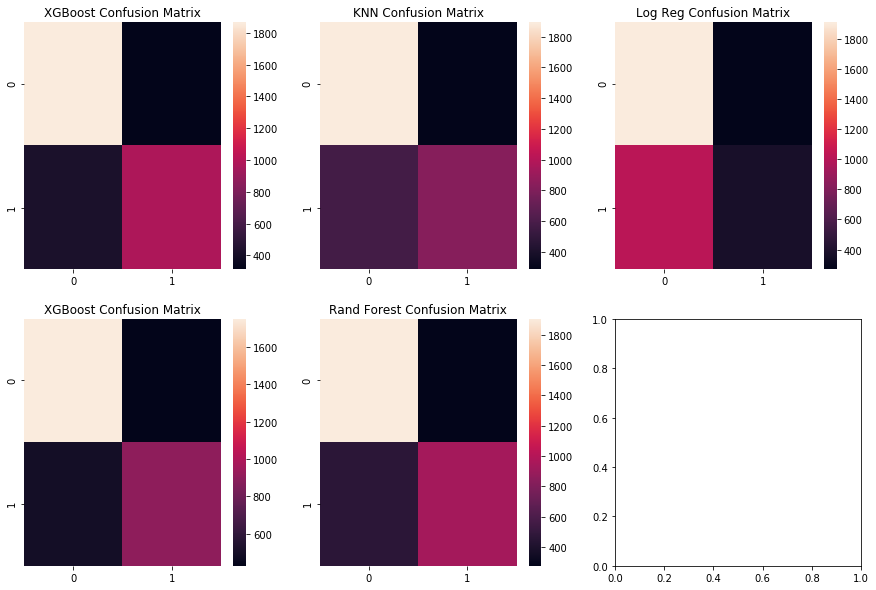

In [46]:
import seaborn as sns

plt.rcParams['figure.figsize'] = 15, 10

figure, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3)
plot1 = sns.heatmap(confusion_matrix(y_test, xgb_y_pred), ax = ax1)
plot1.set_title('XGBoost Confusion Matrix')

plot2 = sns.heatmap(confusion_matrix(y_test, knn_y_pred), ax = ax2)
plot2.set_title('KNN Confusion Matrix')

plot3 = sns.heatmap(confusion_matrix(y_test, log_y_pred), ax = ax3)
plot3.set_title('Log Reg Confusion Matrix')

#plot4 = sns.heatmap(confusion_matrix(y_test, gnb_y_pred), ax = ax4)
#plot4.set_title('Gaussian NB Confusion Matrix')

plot5 = sns.heatmap(confusion_matrix(y_test, dt_y_pred), ax = ax4)
plot5.set_title('XGBoost Confusion Matrix')

plot6 = sns.heatmap(confusion_matrix(y_test, rf_y_pred), ax = ax5)
plot6.set_title('Rand Forest Confusion Matrix')

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

print("AUC: \n{}".format(roc_auc_score(y_test, voting_y_pred))) # 1.00 would be 100% correct model, 0.0 would be 100% wrong model
print("\n")
print("Receiver Operating Characteristic: \n{}".format(roc_curve(y_test, voting_y_pred)))

AUC: 
0.7914711664482307


Receiver Operating Characteristic: 
(array([0.        , 0.13348624, 1.        ]), array([0.        , 0.71642857, 1.        ]), array([2, 1, 0]))


False Positive Rate: [0.         0.13348624 1.        ]
True Positive Rate: [0.         0.71642857 1.        ]


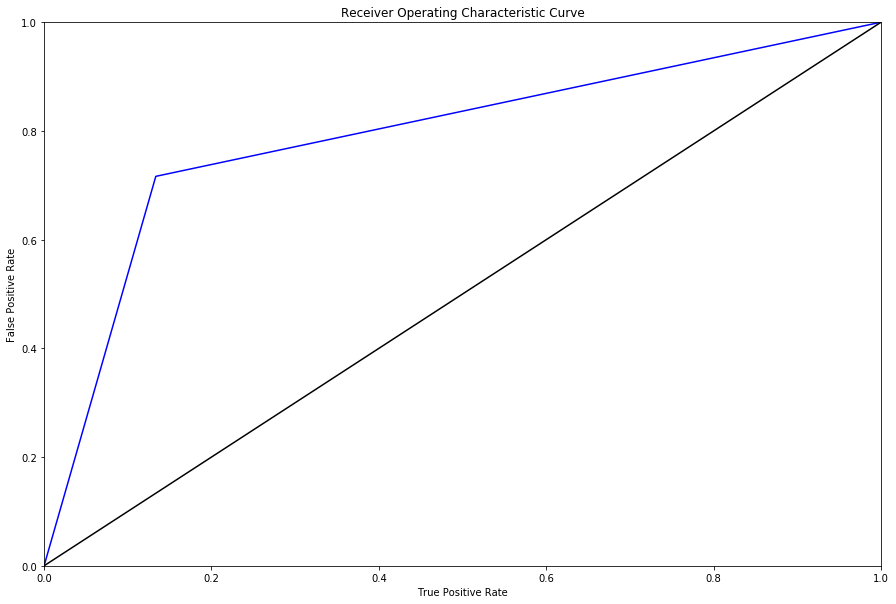

In [48]:
fpr, tpr, threshold = roc_curve(y_test, voting_y_pred)

print("False Positive Rate: {}".format(fpr))
print("True Positive Rate: {}".format(tpr))

roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots(ncols =1)


plt.rcParams['figure.figsize'] = 10, 8
plt.title("Receiver Operating Characteristic Curve")
plt.plot(fpr, tpr, 'b')
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.xlim([0,1])
plt.ylim([0,1])

x = np.linspace(*ax.get_xlim()) # 45 degree line to measure ROC...
plt.plot(x, x, 'black')
# The closer the ROC to the 45 degree line, the less accurate 



In [49]:
print(precision_score(y_test, voting_y_pred))

0.7751159196290572
